#### Name   : Kalyanarathne WMUW
#### Reg No : EG/2018/3357

Github Link : https://github.com/UmeshanUC/Image-Segmentation.git

### Q1

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plotImage(image, name):
  fig, ax = plt.subplots(figsize=(3,3))
  ax.set_title(name)
  ax.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

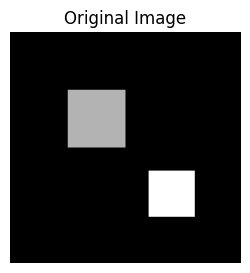

In [14]:

# Create the image with 2 objects and a background
img = np.zeros((400, 400), dtype=np.uint8)
img[100:200, 100:200] = 180
img[240:320, 240:320] = 255

plotImage(img, 'Original Image')

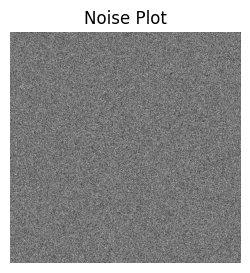

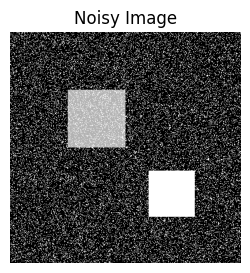

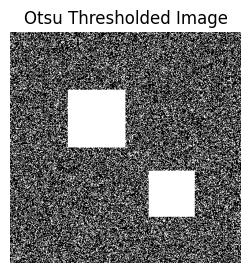

In [15]:
# Implement Otsu's thresholding algorithm
def ApplyOtsuAlgorithm(img):
  hist, bins = np.histogram(img.ravel(), 256, [0, 256])
  # Compute cumulative sum of the histogram
  cumsum = np.cumsum(hist)
  # Compute normalized cumulative sum of the histogram
  norm_cumsum = cumsum / float(cumsum[-1])
  # Compute the between-class variance for all possible threshold values
  w = np.arange(256)
  mean = np.arange(1, 256) * norm_cumsum[1:] + w[1:] * (1 - norm_cumsum[1:])
  variance = norm_cumsum[1:] * (1 - norm_cumsum[1:]) * ((cumsum[-1] - cumsum[1:]) / cumsum[1:]) ** 2
  between_class_variance = cumsum[1:] * (cumsum[-1] - cumsum[1:]) * variance
  # Find the optimal threshold value that maximizes the between-class variance
  threshold = np.argmax(between_class_variance)
  # Apply the threshold to the image
  thresholded_img = np.zeros_like(img)
  thresholded_img[img > threshold] = 255
  
  return thresholded_img;# Add Gaussian noise to the image


noise = np.random.normal(loc=0, scale=1, size=img.shape)
noisy_img = cv2.add(img, noise.astype(np.uint8))

plotImage(noise, 'Noise Plot')
plotImage(noisy_img, 'Noisy Image')


otsu_img = ApplyOtsuAlgorithm(noisy_img)
# _, otsu_img = cv2.threshold(noisy_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plotImage(otsu_img, 'Otsu Thresholded Image')

### Q2

C:\Users\Umeshan\AppData\Local\Temp\ipykernel_12832\2569080340.py:123: RuntimeWarning: overflow encountered in ubyte_scalars
  if abs(image[curr_point.getTuple()] - image[seedPoint.getTuple()]) <= pixel_range:


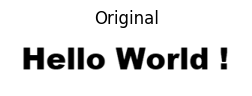

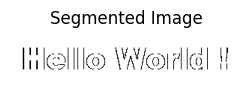

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plotImage(image, name):
    fig, ax = plt.subplots(figsize=(3,3))
    ax.set_title(name)
    ax.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Defines a Point
class Point:
    def __init__(self, position, image):
        '''
        Args:
        position: position of the point as tupple
        image: Residing image as Mat
        '''
        self.pos = position
        self.x, self.y = position
        
        # Get the height and width of the image.
        self.height, self.width = image.shape[:2]
    
    # overload = operator
    def __eq__(self, otherPoint):
        return self.x == otherPoint.x and self.y == otherPoint.y
    
    def isWithinBounds(self):
        '''
        Returns whether the point is in the relevant residing image's limits (Height and Width)
        
        Returns:
        True : Within the limits
        False: Out of the bounds of image (invalid point)
        '''
        if (self.x > self.height-1) or (self.y > self.width-1):
            return False
        if (self.x < 0) or (self.y < 0):
            return False
        return True
    
    def getTuple(self):
        '''
        Returns the tuple corresponding to a the Point
        '''
        return(self.x, self.y)
    
    

#defines a mask with 4 points
class N4_Neighbors:
    def __init__(self, point):
        '''
        Args:
        position: position of the point as Point
        image: Residing image as Mat
        '''
        x, y = point.getTuple()
        
        self.p_N = Point((x, y+1), image)
        self.p_E = Point((x+1, y), image)
        self.p_W = Point((x-1, y), image)
        self.p_S = Point((x, y-1), image)
        
    def addAllValidPointsToQueue(self, queue, processedList):
        '''
        Adds all the valid points haven't processed to given queue.
        Validity based on whether the point is really
        inside the image bounds (heigh, width)
        
        Args:
        queue: the queue that the valid points to be added
        image: residing image. the image that should consider to check the bounds
        processedList: the list of pixels that has processed yet
        '''
        
        if(self.p_N.isWithinBounds() and (self.p_N not in processedList)): 
            queue.append(self.p_N)
        if(self.p_E.isWithinBounds() and (self.p_E not in processedList)): 
            queue.append(self.p_E)
        if(self.p_W.isWithinBounds() and (self.p_W not in processedList)): 
            queue.append(self.p_W)
        if(self.p_S.isWithinBounds() and (self.p_S not in processedList)): 
            queue.append(self.p_S)


def region_growing(image, seedPoint, thresholdRange):
    """
    Region growing algorithm for image segmentation.

    Args:
    image: grayscale image.
    seed: seed point to start segmentation.

    Returns:
    segmented image.
    """
    # Create segmented image with all zeros.
    segmented = np.zeros_like(image)

    # Define pre-defined range of pixel values around the seed points.
    pixel_range = thresholdRange

    #define a list to store processed pixels
    processed = []
    
    # Define a queue for storing the seed points to be processed.
    queue = []
    queue.append(seedPoint)
    
    # While the queue is not empty, continue segmentation.
    while queue:
        # Get the next seed point from the queue.
        curr_point = queue.pop(0)
        
        # Check if the current point has already been processed.
        if curr_point in processed:
            continue
        
        # Check if the pixel is within the range of the seed pixel.
        if abs(image[curr_point.getTuple()] - image[seedPoint.getTuple()]) <= pixel_range:
            # Mark the pixel as foreground.
            segmented[curr_point.getTuple()] = 255
            
        n4_neighbors = N4_Neighbors(curr_point)
        n4_neighbors.addAllValidPointsToQueue(queue, processed)
        processed.append(curr_point)

    return segmented

# Load the image.
imageRaw = cv2.imread("test.png", cv2.IMREAD_GRAYSCALE)
image = cv2.resize(imageRaw, (0,0), fx = 1, fy = 1)

# Choose an initial seed point within the object of interest.
seed_point = Point((10, 10), image)

# Run the region growing algorithm for image segmentation.
segmented = region_growing(image, seed_point, 50)

# Show the original image and segmented image side by side.
plotImage(image, 'Original')
plotImage(segmented, 'Segmented Image')
